# Kernel Eigenvectors and RDE

In this exercise sheet we will examine kernel eigenvectors in the context of a simple one-dimensional dataset and then implement the RDE method for estimating the relevant dimensionality of the dataset, and test it on handwritten digits. The code below loads the usual libraries for array computations and plotting.

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from matplotlib import pyplot as plt

We first consider a one-dimensional dataset consisting of $N=50$ data points. The input data is drawn randomly from a standard Gaussian distribution, and the output is a function of the input to which Gaussian noise is added. We use a seed initialization for the data to allow for exact reproducibility of the results.

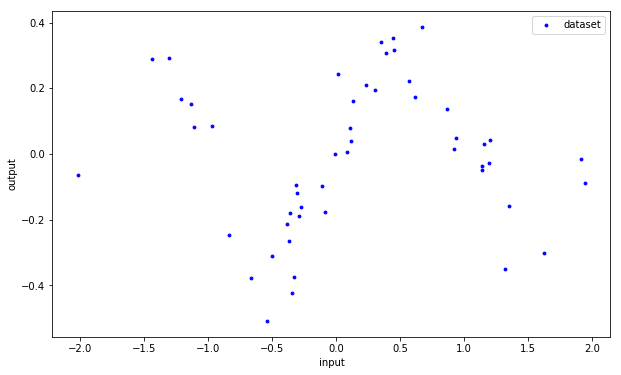

In [2]:
# Initialize random seed
rstate = np.random.mtrand.RandomState(456)

# Produce input and labels
X = rstate.normal(0,1,[50,1])
G = (X*np.sinc(X)+rstate.normal(0,0.1,X.shape))[:,0]

# Plot the dataset
plt.scatter(X[:,0],G,s=8,color='blue',label='dataset')
plt.xlabel('input'); plt.ylabel('output'); plt.legend(); plt.show()

## Kernel eigenvectors (10 P)

The RDE analysis studied here is based on representing the dataset in terms of kernel eigenvectors. We use the following kernel:
$$
k(x_i,x_j) = \exp\Big(-\frac{\|x_i-x_j\|^2}{S}\Big)
$$
where
$$
S = \frac15 \cdot \frac{1}{N^2}\sum_{i=1}^N \sum_{j=1}^N \|x_i-x_j\|^2
$$
is proportional to the mean of squared distances between data points. This term makes the kernel invariant to rescalings of the data. We will use this kernel function for the whole exercise. Then, after having collected a kernel matrix, the kernel eigenvectors can be obtained as a solution of the eigenvalue problem $K u = \lambda u$, where each solution $u$ of this equation is a vector of size $N$. This vector can be plotted as a function in the input space sampled at the same locations as the data points.

**Tasks:**

* *Create* a function `U = get_k_eig_sorted(X)` that takes as input the input data, and outputs a matrix whose columns are the kernel eigenvectors sorted by decreasing associated eigenvalue.

* *Run* the code below that superposes to the data the first three eigenvectors, and the 25th eigenvector

* *Describe* qualitatively the differences between first few eigenvectors and the remaining ones. **[YOUR ANSWER HERE]**

In [3]:
def get_k_eig_sorted(X):
    def get_S(X):
        N = len(X)
        sum_ = 0
        for i in range(N):
            for j in range(N):
                sum_ += np.linalg.norm(X[i] - X[j])**2
        return 1/5 * 1/N**2 * sum_

    def k(x_i, x_j, S):
        return np.exp(-np.linalg.norm(x_i - x_j)**2/S)

    S = get_S(X)
    N = len(X)
    K = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            K[i, j] = k(X[i], X[j], S)

    _, U = np.linalg.eig(K)
    return U

U = get_k_eig_sorted(X)

/home/madness/Documents/Projects/SuperWiseLearners/venv/local/lib/python3.5/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


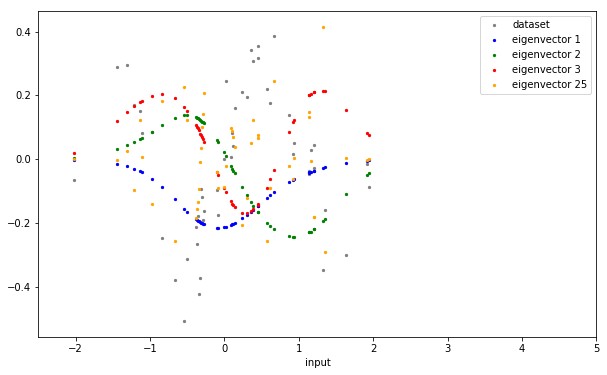

In [4]:
plt.scatter(X[:,0],G,color='gray',s=5,label='dataset')
for i,c in zip([0,1,2,24],['blue','green','red','orange']):
    plt.scatter(X[:,0],U[:,i],color=c,s=5,label='eigenvector %d'%(i+1))
plt.legend(); plt.xlabel('input'); plt.xlim(-2.5,5); plt.show()

## S-Coefficients (10 P)

Having computed the kernel eigenvectors, and verified their appearance, we can now proceed with the RDE analysis, which is based on them. The first part of the analysis consists of plotting "s-coefficients" defined as:
$$
\forall_{i=1}^N: s_i = |u_i^\top G|,
$$
that is, the scalar dot between the label vector and each kernel eigenvector, to which we apply the absolute function.

**Tasks**

* *Create* a function `s = get_s_coeffs(U,G)` that compute these products.

* *Verify* empirically the property $\sum_{i=1}^N s_i^2 = \|G\|^2$ to check your implementation.

* *Run* the code below that plots the s-coefficient associated to each eigenvector.

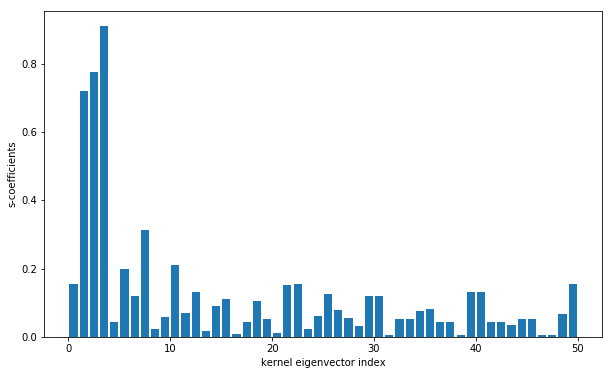

In [5]:
def get_s_coeffs(U, G):
    return np.abs(U.T @ G)

s = get_s_coeffs(U, G)
assert np.sum(s**2) - np.linalg.norm(G)**2 < np.exp(-10)

plt.bar(np.arange(len(s))+0.5,s)
plt.xlabel('kernel eigenvector index')
plt.ylabel('s-coefficients')
plt.show()

## Relevant Dimensionality Estimation (20 P)

The plot above reveals an interesting property of these s-coefficients. The first few of them are large (generally above 0.2), and the remaining one are smaller, but non-zero. Note the presence of a cutoff dimensionality (between the first 4 and 10 eigenvectors) where a fast transition between large coefficients and small coefficients occurs. These statistics of the s-coefficient can be captured using a two-components model described below with a relevant dimensionality cutoff parameter $d$, and where the best parameter $d$ can be found by searching for the one that produces the model with highest log-likelihood. The following is taken from the original paper on RDE and shows the relevant formulas:

![estimation procedure](rde.png)

**Tasks**

* *Create* a function `d,nll = get_nll(s)` that returns a vector of all possible relevant dimensionalities `d` and the associated negative log-likelihood $-\log \ell(d)$. Note that for this dataset, we have `d=[2,3,4,...,49]`, where we have omitted the two border cases `1` and `50`.

* *Run* the code below that shows these log-likelihood values superposed to bar plot of s-coefficients. Note that a constant has been added to the negative log-likelihood values so that both graphs are within the same range.

* *Explain* whether the highest log-likelihood value does correspond to a reasonable relevant dimensionality cutoff, and where multiple choices of relevant dimensionality are possible. **[YOUR ANSWER HERE]**

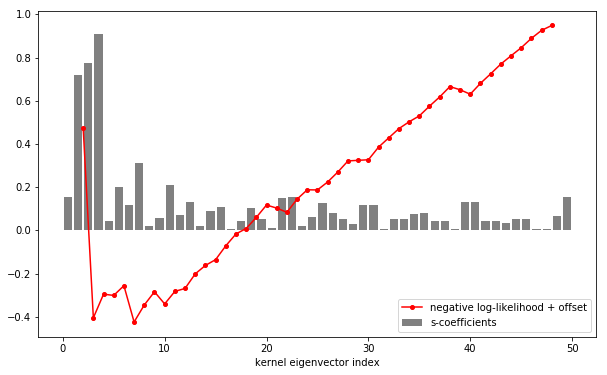

In [6]:
def get_nll(s):
    n = len(s)
    
    def sigma1(d, z):
        sum_ = 0
        for i in range(d):
            sum_ += z[i]**2
        return 1/d * sum_
    
    def sigma2(d, z, n):
        sum_ = 0
        for i in range(d+1, n):
            sum_ += z[i]**2
        return 1/(n-d) * sum_
    
    def nll(d, n):
        z = s
        return d/n * np.log(sigma1(d, z))+(n-d)/n * np.log(sigma2(d, z, n))
    
    d = np.arange(2, n-1)
    return d, np.array([nll(d_i, n) for d_i in d])

d, nll = get_nll(s)

plt.bar(np.arange(len(s))+0.5,s,color='gray',label='s-coefficients')
plt.plot(d,nll+4,'o-',color='red',ms=4,label='negative log-likelihood + offset')
plt.xlabel('kernel eigenvector index')
plt.legend(loc='lower right')
plt.show()

## Application to digits data (10 P)

We now would like to apply the RDE analysis implemented above on a real dataset. We consider a simple dataset of `8x8` pixels digits that we can load from `scikit-learn`. For this exercise, we restrict ourselves to two classes, and represent the class membership as real-values `-1` or `1`. The following code reads the dataset, prepares the class labels, and visualizes the input data in a human-readable fashion.

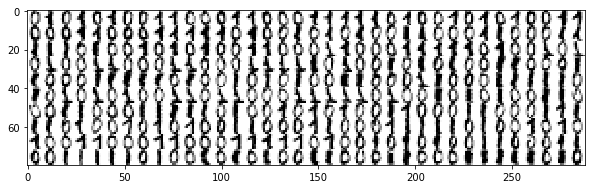

In [7]:
# load the dataset (retain only zeros and ones)
from sklearn.datasets import load_digits
digits = load_digits(n_class=2)

# read input and labels
X = digits['data']*1.0
G = digits['target']*2.0-1.0

# visualize the dataset
Xv = X.reshape(10,36,8,8).transpose(0,2,1,3).reshape(10*8,36*8)
plt.imshow(Xv,cmap='Greys')
plt.show()

**Tasks:**
    
* *Apply* the the same analysis as for the first one-dimensional dataset. (Note that some functions that you have previously implemented might need to be rewritten to be more general, e.g. apply to multidimensional input data or varying number of data points.)

* *Create* a plot superposing a bar plot for the s-coefficients, a plot of the negative log-likelihood as a function of `d`, and an element indicating the optimal number of relevant dimensions (found by maximimzing the log-likelihood of the two-component model).

In [8]:
U = get_k_eig_sorted(X)

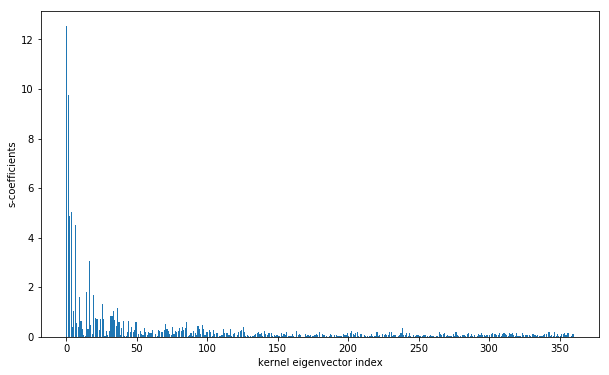

In [9]:
def get_s_coeffs(U, G):
    return np.abs(U.T @ G)

s = get_s_coeffs(U, G)
assert np.sum(s**2) - np.linalg.norm(G)**2 < np.exp(-10)

plt.bar(np.arange(len(s))+0.5,s)
plt.xlabel('kernel eigenvector index')
plt.ylabel('s-coefficients')
plt.show()

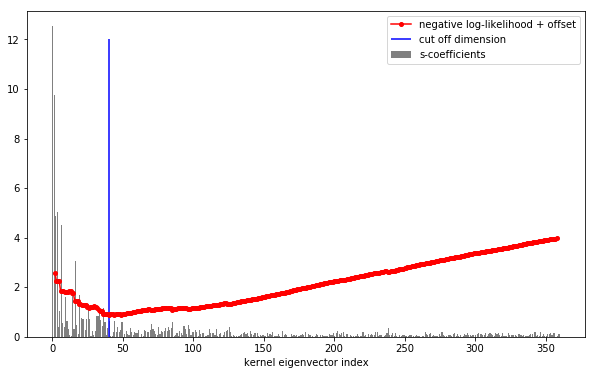

In [17]:
d, nll = get_nll(s)

plt.bar(np.arange(len(s))+0.5,s,color='gray',label='s-coefficients')
plt.plot(d,nll+4,'o-',color='red',ms=4,label='negative log-likelihood + offset')
plt.vlines(np.argmin(nll)+2, 0, 12, label='cut off dimension', colors='blue')
plt.xlabel('kernel eigenvector index')
plt.legend(loc='upper right')
plt.show()